# Econ 428: Problem Set 2

Franklin She, Selina Li

## Problem 1

### 1.

(Omitted, as we are not graduate students)

### 2.

We used the true function $f$ in the last problem set to calculate the true MSE decomposition.

### 3.

Without knowing the true function $f$, we can still do part d again by estimating the conditional Mean Squared Error (MSE) and its decomposition for polynomial regressions of different degrees, using the provided dataset. As we don't know the true function $f$, we use the deviation from the mean of $y$ as an approximation of bias.

In [73]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=UserWarning)


data = pd.read_csv('ps2data.csv')


In [79]:
x_star = 1.7
epsilon = 0.4  # Choosing an epsilon value

# Initialize lists to store the MSE decomposition components
variance_list = []
bias_squared_list = []
intrinsic_noise_list = []
new_bias_squared_list = []

# Fit polynomial regressions and estimate MSE components
for d in range(13):
    # Polynomial features for the full model
    poly = PolynomialFeatures(degree=d)
    X_poly = poly.fit_transform(data[['x']].values)

    # Fit the full polynomial model
    model = LinearRegression().fit(X_poly, data['y'].values)

    # Predictions for variance and original bias squared
    y_pred = model.predict(X_poly)
    variance = np.mean((y_pred - np.mean(y_pred))**2)

    # Predict at x_star using the model
    x_star_poly = poly.transform([[x_star]])
    f_x_star = model.predict(x_star_poly)[0]

    # Bias squared calculation (using f_x_star)
    true_y_at_x_star = ...  # You need to provide the true value at x_star
    bias_squared = (f_x_star - true_y_at_x_star)**2

    residuals = data['y'].values - y_pred
    intrinsic_noise = np.var(residuals)

    variance_list.append(variance)
    bias_squared_list.append(bias_squared)
    intrinsic_noise_list.append(intrinsic_noise)

    # Filter data near X* for local linear approximation
    local_data = data[np.abs(data['x'] - x_star) <= epsilon]

    # Fit a local linear model if there's enough data
    if len(local_data) >= 2:
        local_model = LinearRegression().fit(local_data[['x']], local_data['y'])
        f_x_star_approx = local_model.predict([[x_star]])[0]
    else:
        # Handling the case where there's insufficient local data
        f_x_star_approx = f_x_star  # Use the prediction from the full model

    # New squared bias calculation
    new_bias_squared = (f_x_star_approx - true_y_at_x_star)**2
    new_bias_squared_list.append(new_bias_squared)

# Recalculate MSE with new bias estimation
new_mse = np.array(variance_list) + np.array(new_bias_squared_list) + np.array(intrinsic_noise_list)

# Plotting the results with new bias estimation
plt.figure(figsize=(12, 8))
plt.plot(range(13), variance_list, label='Variance', marker='o')
plt.plot(range(13), new_bias_squared_list, label='New Bias^2', marker='o')
plt.plot(range(13), intrinsic_noise_list, label='Intrinsic Noise', marker='o')
plt.plot(range(13), new_mse, label='New MSE', marker='o')
plt.xlabel('Degree of Polynomial (d)')
plt.ylabel('MSE Components')
plt.title('MSE Decomposition with Local Linear Approximation Bias')
plt.legend()
plt.grid(True)
plt.show()


TypeError: unsupported operand type(s) for -: 'float' and 'ellipsis'

The choice of $\epsilon$ involves a trade-off between bias and variance.

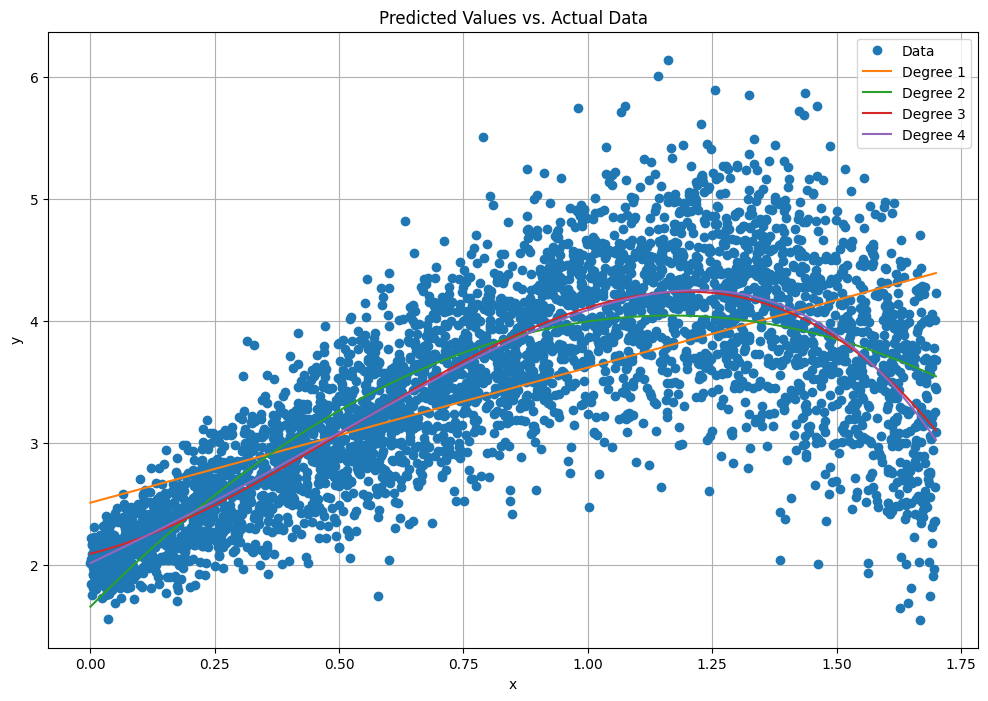

In [75]:
# Prediction point
x_star = 1.7

# Initialize lists to store the MSE decomposition components
variance_list = []
bias_squared_list = []
intrinsic_noise_list = []

# Initialize list to store predicted values
y_hat_list = []

# Fit polynomial regressions and estimate MSE components
for d in range(1, 5): 
    # Polynomial features
    poly = PolynomialFeatures(degree=d)
    X_poly = poly.fit_transform(data[['x']].values)

    # Fit the model
    model = LinearRegression().fit(X_poly, data['y'].values)

    # Predict at x_star
    x_star_poly = poly.transform([[x_star]])
    y_pred_star = model.predict(x_star_poly)[0]

    # Estimating variance component
    y_pred = model.predict(X_poly)
    variance = np.mean((y_pred - np.mean(y_pred))**2)

    # Estimating squared bias component
    # As we don't know the true function f, we use the deviation from the mean of y as an approximation
    bias_squared = (np.mean(y_pred) - np.mean(data['y'].values))**2

    # Estimating intrinsic noise
    # Assuming intrinsic noise is the variance of the residuals
    residuals = data['y'].values - y_pred
    intrinsic_noise = np.var(residuals)

    # Append to lists
    variance_list.append(variance)
    bias_squared_list.append(bias_squared)
    intrinsic_noise_list.append(intrinsic_noise)

    # Predicted values for plotting
    y_hat_list.append(y_pred)

mse = np.array(variance_list) + np.array(bias_squared_list) + np.array(intrinsic_noise_list)

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(data['x'], data['y'], 'o', label='Data')  # Plot the actual data
for d in range(4):  # Modify the range to include degrees 1-4
    plt.plot(data['x'], y_hat_list[d], label=f'Degree {d+1}')  # Plot the predicted values for each degree
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted Values vs. Actual Data')
plt.legend()
plt.grid(True)
plt.show()


### 4.

In [30]:
def cross_validation(dataset, K, model_function, hyperparameters):
    """
    Custom cross-validation function.

    Parameters:
    dataset (DataFrame): The dataset to be used.
    K (int): Number of folds for cross-validation.
    model_function (function): A function that takes a training set, a validation set, and a set of hyperparameters,
                               and returns a performance metric (e.g., MSE).
    hyperparameters (list): A list of hyperparameters to test.

    Returns:
    dict: A dictionary with hyperparameters as keys and their average performance as values.
    """

    # Split dataset into K folds
    folds = np.array_split(dataset, K)
    
    # Dictionary to store the average performance for each hyperparameter
    avg_performance = {hp: 0 for hp in hyperparameters}

    # Perform K-Fold Cross-Validation
    for k in range(K):
        # Prepare validation and training sets
        validation_set = folds[k]
        training_set = pd.concat([folds[i] for i in range(K) if i != k], ignore_index=True)

        # Evaluate each set of hyperparameters
        for hp in hyperparameters:
            performance = model_function(training_set, validation_set, hp)
            avg_performance[hp] += performance / K

    return avg_performance

def polynomial_regression_model(training_set, validation_set, degree):
    """
    Function to fit and evaluate a polynomial regression model.

    Parameters:
    training_set (DataFrame): The training dataset.
    validation_set (DataFrame): The validation dataset.
    degree (int): Degree of the polynomial.

    Returns:
    float: The MSE of the model on the validation set.
    """
    # Polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(training_set[['x']].values)
    X_val_poly = poly.transform(validation_set[['x']].values)

    # Fit the model
    model = LinearRegression().fit(X_train_poly, training_set['y'].values)

    # Predict and calculate MSE
    y_val_pred = model.predict(X_val_poly)
    mse = mean_squared_error(validation_set['y'].values, y_val_pred)

    return mse

# Now, we use this function to find the best polynomial degree from 0 to 30
K = 5  # Number of folds for cross-validation
degrees = list(range(31))  # Degrees from 0 to 30
cv_results = cross_validation(data, K, polynomial_regression_model, degrees)

# Find the degree with the minimum average MSE
best_degree = min(cv_results, key=cv_results.get)
best_degree, cv_results[best_degree]


/Users/franklinshe/Documents/school/econ428/psets/pset2/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


(4, 0.25215135862137994)

### 5.

### 6.

### 7.

Perhaps $f$ is $sin(\cdot)$.

## Problem 2

The expected optimism is defined as the difference between the expected loss on the training data and the true expected loss. For the 0-1 loss, the expected optimism can be expressed as the sum of the covariances between the predicted and actual outcomes divided by the number of observations:

$$
E[\text{optimism}] = \frac{1}{n} \sum_{i=1}^n Cov(\hat{y}_i, y_i)
$$

Given that $ y_i $ and $ \hat{y}_i $ are both binary, taking values in \{0, 1\}, we express the covariance between $ \hat{y}_i $ and $ y_i $ as:

$$
Cov(\hat{y}_i, y_i) = E[(\hat{y}_i - E[\hat{y}_i])(y_i - E[y_i])]
$$

Here, $ E[y_i] $ is the probability of $ y_i $ being 1, and $ E[\hat{y}_i] $ is the estimated probability that $ \hat{y}_i $ is 1 based on the model. 

For the 0-1 loss, this covariance captures the dependence between the predictions and the true labels. If the model's predictions are independent of the true labels, the covariance (and thus the expected optimism) will be zero. If the predictions are perfectly dependent on the true labels (i.e., the model is perfect), then the covariance will be positive, increasing the expected optimism.

Hence, the formula for expected optimism is valid for 0-1 loss when $ Y $ is binary.


## Problem 3

In [69]:
import numpy as np

np.random.seed(42)  # For reproducibility

n = 1000  # Number of individuals

# Potential outcomes
mean_y_d0 = 50  # Mean of Y_i(0)
mean_y_d1 = 70  # Mean of Y_i(1)
std_dev = 10  # Standard deviation for both

Y_d0 = np.random.normal(mean_y_d0, std_dev, n)  # Potential outcomes for untreated
Y_d1 = np.random.normal(mean_y_d1, std_dev, n)  # Potential outcomes for treated

# Scenario 1: More heavily biased treatment assignment
# Increasing the slope of the logistic function to create a stronger dependency on Y_d1
probability_of_treatment_more_biased = 1 / (1 + np.exp(-0.1 * (Y_d1 - 60)))  # Steeper slope
D_more_biased = np.random.binomial(1, probability_of_treatment_more_biased, n)

# Actual outcomes based on more biased treatment assignment
Y_more_biased = np.where(D_more_biased == 1, Y_d1, Y_d0)

# Calculate the difference in means for more biased treatment assignment
diff_in_means_more_biased = np.mean(Y_more_biased[D_more_biased == 1]) - np.mean(Y_more_biased[D_more_biased == 0])

# Scenario 2: Random treatment assignment (independent of potential outcomes)
D_random = np.random.binomial(1, 0.5, n)  # Assign treatment randomly with a probability of 0.5

# Actual outcomes based on random treatment assignment
Y_random = np.where(D_random == 1, Y_d1, Y_d0)

# Calculate the difference in means for random treatment assignment
diff_in_means_random = np.mean(Y_random[D_random == 1]) - np.mean(Y_random[D_random == 0])

print("Difference in means for more biased treatment assignment:", diff_in_means_more_biased)
print("Difference in means for random treatment assignment:", diff_in_means_random)



Difference in means for more biased treatment assignment: 22.363747440585534
Difference in means for random treatment assignment: 20.805624921167038


When the treatment $D$ is not independent of the potential outcomes, the equation (2) does not estimate the ATE, but when the treatment is randomly assigned (therefore, independent), (2) does estimate the ATE.

## Problem 4

(Omitted, as we are not graduate students)